In [ ]:
import nltk
from nltk.corpus import movie_reviews as mr, stopwords, wordnet, sentiwordnet as swn
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.wsd import lesk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from functools import lru_cache
import matplotlib.pyplot as plt
import string
from collections import defaultdict
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import wordnet as wn
import seaborn as sns
import numpy as np
import pandas as pd

# Descarregar recursos necesaris
nltk.download('movie_reviews')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('sentiwordnet')

# Configuració inicial
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
vader_analyzer = SentimentIntensityAnalyzer()


[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\34644\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\34644\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\34644\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\34644\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\34644\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\34644\AppData\Roaming\nltk_data...
[nltk_data]   Package senti

In [ ]:
# Pesos per categoria gramatical
CATEGORY_WEIGHTS = {
    'a': 2.0,  # Adjectius
    'n': 0.6,  # Sustantius
    'v': 0.8,  # Verbs
    'r': 0.7   # Adverbis
}

In [ ]:
# Carregar les dades
documents = [(list(mr.words(fileid)), category)
             for category in mr.categories()
             for fileid in mr.fileids(category)]

In [ ]:
# Mateix preprocés que abans
def preprocess_text(text):
    processed = []
    for word in text:
        if word.isalpha() and word.lower() not in stop_words and len(word) > 2:
            word = word.lower()
            processed.append(word)
    return processed

texts = [preprocess_text(words) for words, _ in documents]
labels = [label for _, label in documents]


In [ ]:
# Dividir dades
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.3, random_state=123, stratify=labels)

In [ ]:
# Funció per obtenir el pos tag de les paraules
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, 
                "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Lemmatizació
def normalize_text(text):
    return [lemmatizer.lemmatize(word, get_wordnet_pos(word)) 
            for word in text]

X_test_lem = [normalize_text(text) for text in X_test]

# Raó per retornar **wordnet.NOUN** per defecte

1. **Freqüència en text**  
   Els noms són la categoria gramatical més comuna en textos generals.

2. **Versatilitat lingüística**  
   Moltes paraules en anglès poden funcionar com a noms o ser interpretades com a noms, fins i tot quan tenen altres significats.

3. **Gestió d'errors**  
   Quan no es pot determinar amb certesa la categoria gramatical d'una paraula, assumir que és un nom:  
   - Minimitza el risc d'errors greus  
   - Proporciona un comportament predictible

4. **Cobertura en lexicons**  
   Tant **SentiWordNet** com **WordNet** tenen:  
   - Més entrades per a noms que per a altres categories  
   - Estructures més completes per a substantius

In [ ]:
# Cache pels synsets
@lru_cache(maxsize=5000)
def cached_senti_synset(synset_name):
    try:
        return swn.senti_synset(synset_name)
    except:
        return None

In [ ]:
def get_senti_synset(word, context, categories):
    # Diccionari per mapear categories gramaticals entre NLTK i WordNet
    pos_map = {'n': wn.NOUN, 'v': wn.VERB, 'a': wn.ADJ, 'r': wn.ADV}
    
    best_synset = None
    best_score = -1
    
    # Obtenir tots els synsets per a la paraula
    word_synsets = wn.synsets(word)

    # Iterar per cada categoria gramatical proporcionada
    for category in categories:
        if category not in pos_map:
            continue
        
        wordnet_pos = pos_map[category]
        
        # Utilitzar l'algorisme de Lesk per desambiguació de sentit
        synset = lesk(context, word, wordnet_pos)
        
        # Si es trova un synset
        if synset:
            # Calcular una puntuació de similitud amb Wu-Palmer amb els altres synsets de la paraula
            # Utilitzem Wu-Palmer perquè és més robust quan es tracta de la comparació semàntica 
            score = sum(synset.wup_similarity(w) or 0 for w in word_synsets)
            
            # Actualitzar el millor synset si la puntuació és més alta
            if score > best_score:
                best_score = score
                best_synset = synset
    
    # Retornar el millor synset trobat
    return best_synset

#for word in X_test_lem[0]:
#        synset = get_senti_synset(word, X_test[0], ['a', 'n', 'v', 'r'])  

In [ ]:
def analyze_sentiment(sentence, categories=['a', 'n', 'v', 'r']):
    """Analiza el sentimiento de una frase usando SentiWordNet"""
    pos_total, neg_total, count, c_neg, c_pos = 0, 0, 0, 0, 0
    
    for word in sentence:
        synset = get_senti_synset(word, sentence, categories)  

        if not synset:
            continue  # Si no troba cap synset, passa al següent
        
        swn_synset = cached_senti_synset(synset.name())

        if swn_synset and hasattr(swn_synset, 'pos_score') and hasattr(swn_synset, 'neg_score'):
            pos_score = swn_synset.pos_score() 
            neg_score = swn_synset.neg_score() 
            
            pos_total += pos_score
            neg_total += neg_score 
            count += 1  

            c_neg += int(neg_score > 0)
            c_pos += int(pos_score > 0)

    if c_pos > 0:
        mean_pos = pos_total / c_pos
    else:
        mean_pos = 0

    if c_neg > 0:
        mean_neg = neg_total / c_neg
    else:
        mean_neg = 0

    print(f"Positives: {c_pos} Negatives: {c_neg}")
    print(f"Mean positives: {mean_pos} Mean negatives: {mean_neg}")

    final_score = pos_total - neg_total
    return "neg" if final_score < 0 else "pos" if final_score > 0 else "neu", final_score


In [232]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = []  # Prediccions del model
y_true = []  # Etiquetes reals

for i in range(len(X_test_lem)):    
    print("*"*20)
    pred, _ = analyze_sentiment(X_test_lem[i], categories=['a'])
    print(f"{pred} → {y_test[i]}")
    
    y_pred.append(pred)  # Guarda la predicció
    y_true.append(y_test[i])  # Guarda la realitat

# Calcula la matriu de confusió
cm = confusion_matrix(y_true, y_pred, labels=["pos", "neg", "neu"])  # Assegura't que les etiquetes coincideixen
print("Matriu de Confusió:")
print(cm)

********************
None
Synset('dirty.a.04')
None
None
None
None
None
None
None
None
None
None
None
None
Synset('back.a.01')
None
None
Synset('top.a.01')
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
Synset('less.a.01')
None
None
None
None
None
Synset('multiple.a.01')
None
Synset('like.a.02')
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
Synset('go.a.01')
None
Synset('american.a.02')
None
None
None
Synset('light.a.06')
None
None
None
None
None
None
Synset('unlike.a.01')
None
None
None
Synset('human.a.03')
None
None
None
None
None
Synset('dominant.a.02')
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
Synset('present.a.02')
None
Synset('judicial.a.03')
None
None
None
Synset('shakespearian.a.01')
None
None
None
None
None
Synset('good.a.01')
None
None
None
None

In [233]:
cnt = 0

for i in range(len(y_true)):
    if y_true[i] == y_pred[i]:
        cnt += 1

In [234]:
print(cnt/len(y_true))

0.58


**Experimentació**

In [ ]:
def analyze_sentiment(sentence, categories=['a', 'n', 'v', 'r'], peso_pos=1, peso_neg=1):
    pos_total, neg_total, count, c_neg, c_pos = 0, 0, 0, 0, 0
    for word in sentence:
        # Obtenir el synset mitjançant lesk
        synset = get_senti_synset(word, sentence, categories)
        swn_synset = None
       
        # Si hi ha synset, busquem a SentiWordNet
        if synset:
            swn_synset = cached_senti_synset(synset.name())
        
        # Si no hi ha synset, provar amb hiperònims
        if not swn_synset and synset:
            for hypernym in synset.hypernyms():
                swn_synset = cached_senti_synset(hypernym.name())
                if swn_synset:
                    break
        
        # Si no hi ha synset, provar amb hipònims
        if not swn_synset and synset:
            for hyponym in synset.hyponyms():
                swn_synset = cached_senti_synset(hyponym.name())
                if swn_synset:
                    break
        
        # VADER fallback, com a última instància
        if not swn_synset:
            vader_scores = vader_analyzer.polarity_scores(word)
            pos_score = max(0, vader_scores['pos'])
            neg_score = max(0, vader_scores['neg'])
            
            pos_total += pos_score
            neg_total += neg_score 
            count += 1
            
            c_neg += int(neg_score > 0)
            c_pos += int(pos_score > 0)
            continue
        
        # SentiWordNet processat
        if swn_synset and hasattr(swn_synset, 'pos_score') and hasattr(swn_synset, 'neg_score'):
            pos_score = swn_synset.pos_score() * CATEGORY_WEIGHTS.get(synset.pos(), 0.1)
            neg_score = swn_synset.neg_score() * CATEGORY_WEIGHTS.get(synset.pos(), 0.1)
            pos_total += pos_score
            neg_total += neg_score 
            count += 1  

            c_neg += int(neg_score > 0)
            c_pos += int(pos_score > 0)

    # Calcular les mitjanes de puntuació
    mean_pos = pos_total / c_pos if c_pos > 0 else 0
    mean_neg = neg_total / c_neg if c_neg > 0 else 0

    #print(f"Positives: {c_pos} Negatives: {c_neg}")
    #print(f"Mean positives: {mean_pos} Mean negatives: {mean_neg}")

    # Determine final sentiment
    final_score = (pos_total * peso_pos) - (neg_total * peso_neg)
    return ("neg" if final_score < 0 else "pos" if final_score > 0 else "neu", final_score)

In [240]:
y_pred = []  # Prediccions del model
y_true = []  # Etiquetes reals

for i in range(len(X_test_lem[:25])):    
    print("*"*20)
    pred, _ = analyze_sentiment(X_test_lem[i], categories=['a', 'n', 'v', 'r'])
    print(f"{pred} → {y_test[i]}")
    
    y_pred.append(pred)  # Guarda la predicció
    y_true.append(y_test[i])  # Guarda la realitat

# Calcula la matriu de confusió
cm = confusion_matrix(y_true, y_pred, labels=["pos", "neg", "neu"])  # Assegura't que les etiquetes coincideixen
print("Matriu de Confusió:")
print(cm)

********************
Positives: 39 Negatives: 22
Mean positives: 0.3301282051282051 Mean negatives: 0.3409090909090909
pos → neg
********************
Positives: 38 Negatives: 36
Mean positives: 0.3782894736842105 Mean negatives: 0.3576388888888889
pos → neg
********************
Positives: 59 Negatives: 48
Mean positives: 0.3665254237288136 Mean negatives: 0.3359375
pos → neg
********************
Positives: 90 Negatives: 60
Mean positives: 0.33055555555555555 Mean negatives: 0.30625
pos → pos
********************
Positives: 47 Negatives: 36
Mean positives: 0.3191489361702128 Mean negatives: 0.3611111111111111
pos → neg
********************
Positives: 40 Negatives: 32
Mean positives: 0.2875 Mean negatives: 0.2890625
pos → pos
********************
Positives: 27 Negatives: 25
Mean positives: 0.35185185185185186 Mean negatives: 0.315
pos → neg
********************
Positives: 129 Negatives: 66
Mean positives: 0.3643410852713178 Mean negatives: 0.4185606060606061
pos → pos
*******************

In [ ]:
import optuna

#Totes les categories haurien de incloure la categoria 'a' (adjectius)
all_category_combinations = [['a'],['a','n'],['a','v'],['a','r'],['n', 'v', 'a'],['a','r','v'],['a','r','n'],['a','n','v','r']]
def objective(trial):
    # Buscar els millors pesos per a cada categoria gramatical
    CATEGORY_WEIGHTS['a'] = trial.suggest_float('a', 0.1, 10)
    CATEGORY_WEIGHTS['n'] = trial.suggest_float('n', 0.1, 10)
    CATEGORY_WEIGHTS['v'] = trial.suggest_float('v', 0.1, 10)
    CATEGORY_WEIGHTS['r'] = trial.suggest_float('r', 0.1, 10)

    # Buscar els millors pesos per a les categories
    peso_pos = trial.suggest_float('peso_pos', 0.5, 2.0)
    peso_neg = trial.suggest_float('peso_neg', 0.5, 2.0)

    # Seleccionar una combinació de categorias de la llista pre-generada
    selected_categories = all_category_combinations[trial.suggest_int('categories_idx', 0, len(all_category_combinations) - 1)]

    # Evaluar la configuració
    count = 0
    for i in range(len(X_test_lem)):    
        pred, _ = analyze_sentiment(
            X_test_lem[i], 
            categories=selected_categories, 
            peso_pos=peso_pos, 
            peso_neg=peso_neg
        )
        if pred == y_test[i]:
            count += 1

    accuracy = count / len(X_test_lem)
    return accuracy




In [266]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  
# Mostrar los mejores hiperparámetros encontrados
print("Mejor configuración encontrada:", study.best_params)
print("Mejor accuracy:", study.best_value)



[I 2025-03-25 00:46:14,064] A new study created in memory with name: no-name-317d3f04-87f6-4ad3-a7fa-2e07f0877c23
[I 2025-03-25 00:51:33,095] Trial 0 finished with value: 0.5016666666666667 and parameters: {'a': 2.272098667595888, 'n': 5.6017226315928506, 'v': 9.275511289659562, 'r': 1.1271426036240575, 'peso_pos': 1.9072051580162401, 'peso_neg': 0.8709810921180626, 'categories_idx': 4}. Best is trial 0 with value: 0.5016666666666667.
[I 2025-03-25 00:53:04,238] Trial 1 finished with value: 0.5233333333333333 and parameters: {'a': 7.592637486768023, 'n': 8.964188136508053, 'v': 9.603874423520763, 'r': 3.203375200304171, 'peso_pos': 1.6741568001892593, 'peso_neg': 1.3051260384729424, 'categories_idx': 2}. Best is trial 1 with value: 0.5233333333333333.
[I 2025-03-25 00:53:29,154] Trial 2 finished with value: 0.5783333333333334 and parameters: {'a': 4.618122107853271, 'n': 2.622565015235176, 'v': 5.863868924217672, 'r': 2.4146916933787503, 'peso_pos': 0.7492114687026417, 'peso_neg': 1.34

Mejor configuración encontrada: {'a': 7.745252884537532, 'n': 5.173188066242901, 'v': 4.80985852150609, 'r': 7.7869153811286065, 'peso_pos': 1.159936307472053, 'peso_neg': 1.718551874498925, 'categories_idx': 5}
Mejor accuracy: 0.6266666666666667


In [ ]:
#Mejor configuración encontrada: {'a': 7.745252884537532, 'n': 5.173188066242901, 'v': 4.80985852150609, 'r': 7.7869153811286065, 'peso_pos': 1.159936307472053, 'peso_neg': 1.718551874498925, 'categories_idx': 5}
#Mejor accuracy: 0.6266666666666667

('a', 'n', 'v')

In [267]:
CATEGORY_WEIGHTS = {
    'a': 7.745252884537532,  # Adjetivos
    'n': 5.173188066242901,  # Sustantivos
    'v': 4.80985852150609,  # Verbos
    'r': 7.7869153811286065   # Adverbios
}

peso_pos = 1.159936307472053
peso_neg = 1.718551874498925

categories = all_category_combinations[5]

In [ ]:
# Inicialización de variables
y_pred = []
errors = []

# Evaluamos el modelo en el conjunto de test
for i in range(len(X_test_lem)):    
    pred, score = analyze_sentiment(
        X_test_lem[i], 
        categories=categories, 
        peso_pos=peso_pos, 
        peso_neg=peso_neg
    )
    y_pred.append(pred)
    
    if pred != y_test[i]:
        errors.append((X_test_lem[i], y_test[i], pred, score))


Accuracy del modelo: 0.6267
Errores encontrados: 224 de 600 muestras (37.33%)


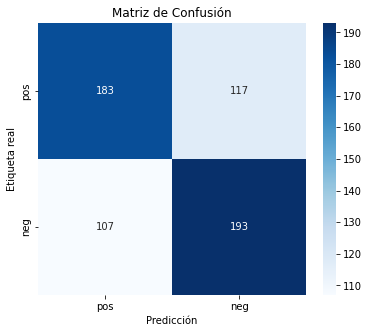


🔹 Clasificación detallada:
              precision    recall  f1-score   support

         pos       0.62      0.64      0.63       300
         neg       0.63      0.61      0.62       300

    accuracy                           0.63       600
   macro avg       0.63      0.63      0.63       600
weighted avg       0.63      0.63      0.63       600


🔹 Ejemplos de errores:
- Texto: corruptor big silly mess action movie complete pointless plot turn gratuitous violence abhorrent even blatantly unlikable make shred sense whose idea director glengarry glen ross direct action film james foley know lot character act strength corruptor quiet scene clash ludicrous action nonsense result less like movie like derail train least chow yun fat lead role chow play nick chen chinatown cop good cop first scene establish familiar chinatown probably power decide team rookie name danny wallace mark wahlberg nick danny begin step toe finally end like get chance save one life happens kind mystery fairly

In [274]:
# Calcular Accuracy
accuracy = sum(np.array(y_pred) == np.array(y_test)) / len(y_test)

# Resultados
print(f"Accuracy del modelo: {accuracy:.4f}")
print(f"Errores encontrados: {len(errors)} de {len(X_test_lem)} muestras ({(len(errors)/len(X_test_lem))*100:.2f}%)")


# Generar la matriz de confusión
labels = ['pos', 'neg']
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Graficar la matriz de confusión
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión")
plt.show()

# Mostrar reporte de clasificación
print("\n🔹 Clasificación detallada:")
print(classification_report(y_test, y_pred, target_names=labels))

# Mostrar algunos errores de clasificación
print("\n🔹 Ejemplos de errores:")
for i in range( len(errors)):  # Mostramos hasta 10 errores
    text, real_label, predicted_label, score = errors[i]
    print(f"- Texto: {' '.join(text)}")
    print(f"  ✅ Etiqueta real: {real_label}")
    print(f"  ❌ Predicción: {predicted_label} (Score: {score:.4f})")
    print("-" * 50)

In [ ]:
from collections import Counter
from nltk.util import bigrams

# Diccionarios para contar palabras y bigramas en cada tipo de error
errors_neg_to_pos = Counter()
errors_pos_to_neg = Counter()

# Analizar errores
for i in range(len(X_test_lem)):
    predicted, score = analyze_sentiment(X_test_lem[i], categories=categories, 
                                         peso_pos=peso_pos, peso_neg=peso_neg)
    true_label = y_test[i]

    if predicted != true_label:
        words = X_test_lem[i]
        bigram_list = [' '.join(bg) for bg in bigrams(words)]  # Crear bigramas
        
        # Contar palabras y bigramas en cada tipo de error
        if true_label == "neg" and predicted == "pos":
            errors_neg_to_pos.update(words + bigram_list)
        elif true_label == "pos" and predicted == "neg":
            errors_pos_to_neg.update(words + bigram_list)


In [ ]:
# Mostrar las palabras y bigramas más comunes en cada tipo de error
print("🔴 Más comunes en errores de PRED NEG → TRUE POS:")
print(errors_neg_to_pos.most_common(25))

print("\n🔵 Más comunes en errores de PRED POS → TRUE NEG:")
print(errors_pos_to_neg.most_common(25))


🔴 Más comunes en errores de PRED NEG → TRUE POS:
[('film', 556), ('movie', 415), ('one', 291), ('get', 234), ('like', 229), ('make', 212), ('character', 203), ('well', 200), ('good', 184), ('even', 177), ('time', 165), ('scene', 147), ('see', 137), ('would', 132), ('seem', 122), ('really', 120), ('go', 119), ('come', 115), ('look', 115), ('give', 112), ('story', 111), ('thing', 104), ('know', 103), ('plot', 102), ('say', 101)]

🔵 Más comunes en errores de PRED POS → TRUE NEG:
[('film', 725), ('one', 341), ('movie', 282), ('make', 252), ('like', 210), ('see', 207), ('character', 204), ('get', 189), ('time', 187), ('life', 172), ('scene', 147), ('story', 146), ('take', 144), ('two', 137), ('much', 134), ('even', 130), ('also', 126), ('way', 123), ('year', 120), ('would', 114), ('well', 114), ('come', 112), ('go', 110), ('end', 106), ('give', 106)]


C:\Users\34644\AppData\Local\Temp\ipykernel_23816\4274459776.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frequencies, y=words, palette='viridis')


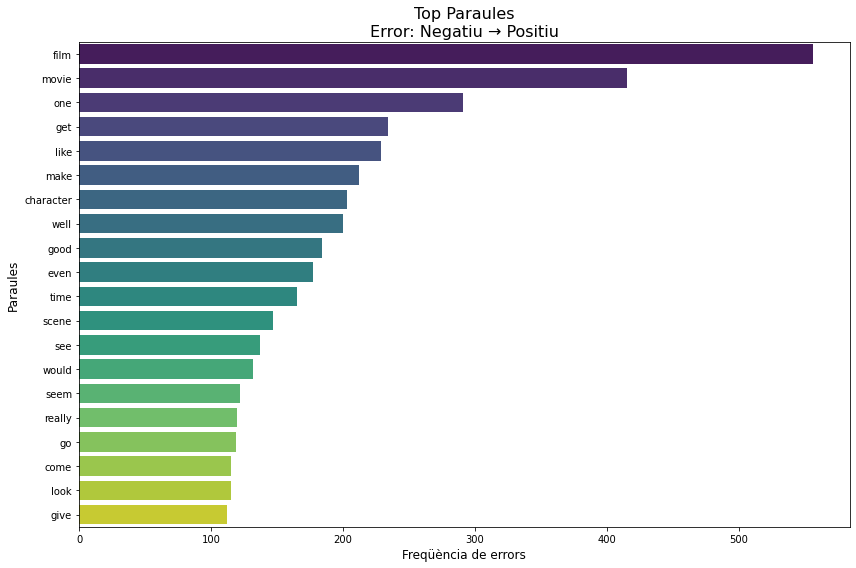

C:\Users\34644\AppData\Local\Temp\ipykernel_23816\4274459776.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frequencies, y=words, palette='viridis')


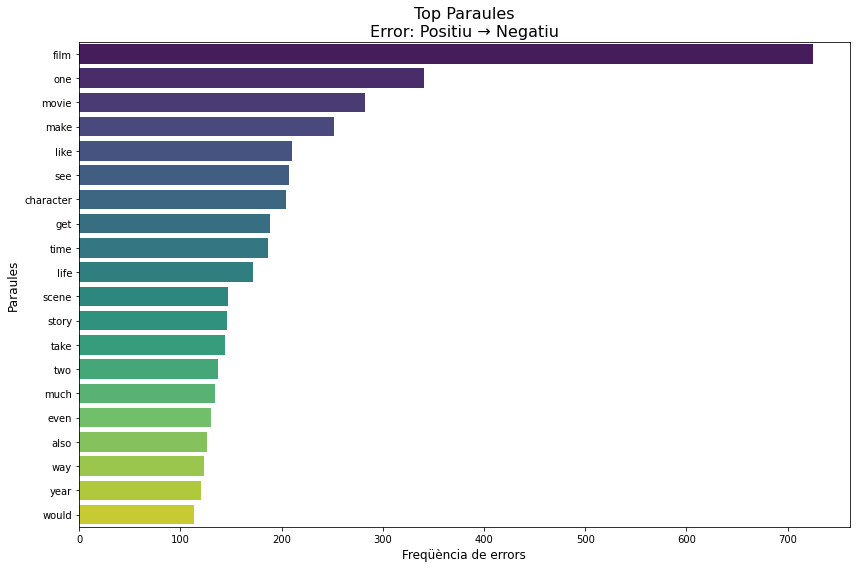

<Figure size 432x288 with 0 Axes>

In [280]:
def plot_error_analysis(errors_dict, title, top_n=20):
    top_errors = errors_dict.most_common(top_n)
    
    words = [item[0] for item in top_errors]
    frequencies = [item[1] for item in top_errors]
    
    plt.figure(figsize=(12, 8))
    
    sns.barplot(x=frequencies, y=words, palette='viridis')
    
    plt.title(title, fontsize=16)
    plt.xlabel('Freqüència de errors', fontsize=12)
    plt.ylabel('Paraules', fontsize=12)
    
    plt.tight_layout()
    plt.show()



plot_error_analysis(errors_neg_to_pos, 'Top Paraules\nError: Negatiu → Positiu')


plot_error_analysis(errors_pos_to_neg, 'Top Paraules\nError: Positiu → Negatiu')

plt.tight_layout()
plt.show()
